## CNN Regression on Galsim simulation data
Ziwei Qiu: ziweiqiu@g.harvard.edu,   
Dan Cox: daniel_cox@g.harvard.edu

Mount My Google Drive to get data into Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import libraries

In [0]:
import sys
import math
#import galsim
import matplotlib.pyplot as plt
import h5py
import numpy as np 
import random 
import copy 
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(threshold=sys.maxsize)

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


###  Import data, make train and test datasets

**The 'label' in the data set is a concatenate of physical parameters (flux, sersic index, sersic radius, g1, g2). g1 and g2 are reduced shear, reparametrization of the ellipticity and orientation. g1= (1-q)/(1+q) cos phi and g2= (1-q)/(1+q) sin phi, where q is ellipticity and phi is orientation. ***

Here is literature: http://2017.ds3-datascience-polytechnique.fr/wp-content/uploads/2017/08/DS3_posterID_012.pdf

In [8]:
label_names_list = ['flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
f= h5py.File('/content/drive/My Drive/Data1.h5','r')
total_num = f['img'][:].shape[0]
print('total number of images:',total_num)
split = int(0.8*total_num)

total number of images: 18779


In [22]:
np.random.seed(100)
ind = np.arange(total_num)
np.random.shuffle(ind)
train_ind = ind[0:split]
train_ind = list(np.sort(train_ind))
test_ind = ind[split:]
test_ind = list(np.sort(test_ind))
print('random indices created.')

# train dataset
image_tr = f['img'][train_ind]
cat_tr = f['cat'][train_ind]  
label_tr = f['label'][train_ind]   # this gives the set of parameters that characterize the galaxy 
snr_tr = f['snr'][train_ind]
sigma_tr = f['sigma'][train_ind]
image_nonoise_tr = f['img_nonoise'][train_ind]    
image_withnoise_tr = f['img_withnoise'][train_ind]
print('training set done.')

# test dataset
image_te = f['img'][test_ind]
cat_te = f['cat'][test_ind]  
label_te = f['label'][test_ind]   # this gives the set of parameters that characterize the galaxy 
snr_te = f['snr'][test_ind]
sigma_te = f['sigma'][test_ind]
image_nonoise_te = f['img_nonoise'][test_ind]    
image_withnoise_te = f['img_withnoise'][test_ind]   
print('test set done.')

# Reshape such that the images are ready for training
image_tr = image_withnoise_tr.reshape(image_tr.shape[0],64,64,1)
image_te = image_withnoise_te.reshape(image_te.shape[0],64,64,1)

random indices created.
training set done.
test set done.


In [0]:
# Rescale the labels
# Standardize to normal(0,1)
standard_scaler = StandardScaler()
standard_scaler.fit(label_tr)
label_tr_scaled = standard_scaler.transform(label_tr)
label_te_scaled = standard_scaler.transform(label_te)

### Make a CNN with input the galaxy images in batches of 64 and output the five galaxy parameters: flux, sersic index, sersic radius, g1, g2


In [56]:
cnnmodel = models.Sequential()
#cnnmodel.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1))

cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1))

cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))

cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))

cnnmodel.add(layers.Flatten())
cnnmodel.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel.add(layers.Dense(5, activation='linear'))
cnnmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 64, 64, 64)        1088      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 64)        65600     
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        32800     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 32)       

In [0]:
cnnmodel.compile(loss='mse', optimizer=Adam(lr=0.0001))

## Fit the model to all the data

In [58]:
%time 
# Fit the model  
verbose, epochs = 1, 50

history = cnnmodel.fit(
      image_tr,
      label_tr_scaled,
      epochs=epochs,
      verbose=verbose,
      batch_size=64,
      shuffle=True,
      validation_data=(image_te, label_te_scaled ) )


cnnmodel.save('cnnmodel.h5')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs
Epoch 1/50
235/235 [==============================] - 7s 31ms/step - loss: 1.2736 - val_loss: 0.9595
Epoch 2/50
235/235 [==============================] - 7s 30ms/step - loss: 0.9326 - val_loss: 0.8449
Epoch 3/50
235/235 [==============================] - 7s 30ms/step - loss: 0.8415 - val_loss: 0.7524
Epoch 4/50
235/235 [==============================] - 7s 30ms/step - loss: 0.7617 - val_loss: 0.6713
Epoch 5/50
235/235 [==============================] - 7s 30ms/step - loss: 0.6825 - val_loss: 0.5961
Epoch 6/50
235/235 [==============================] - 7s 30ms/step - loss: 0.6124 - val_loss: 0.5365
Epoch 7/50
235/235 [==============================] - 7s 30ms/step - loss: 0.5599 - val_loss: 0.5175
Epoch 8/50
235/235 [==============================] - 7s 30ms/step - loss: 0.5261 - val_loss: 0.4833
Epoch 9/50
235/235 [==============================] - 7s 30ms/step - loss: 0.4946 - val_loss: 0.4514
Epoch 10/50
235/235 [==

### plot train and test loss

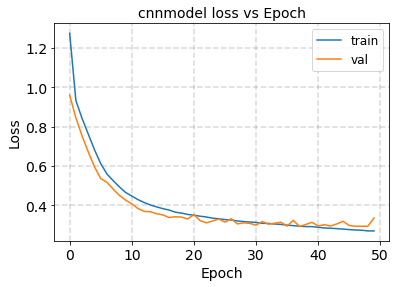

In [59]:
# plotting accuracy and loss 
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('cnnmodel loss vs Epoch', fontsize = 14)
ax.set_ylabel('Loss', fontsize = 14)
ax.set_xlabel('Epoch', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.legend(['train', 'val'], loc='best', fontsize = 12)
ax.grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)



### A function to plot predictions against true values

In [0]:
# Evaluation. modified from Ziwei's function
def plot_prediction(cnnmodel, label_ind, num_of_pts = 200):

    indices = np.random.randint(0,image_te.shape[0],num_of_pts)
    #single_scaler = MinMaxScaler()
    single_scaler = StandardScaler()
    #single_scaler.fit(np.expand_dims(label_tr,axis=1))
    single_scaler.fit(label_tr)

    label_pred_scaled = cnnmodel.predict(image_te[indices])
    label_pred = single_scaler.inverse_transform(label_pred_scaled)

    fig= plt.figure(figsize=(5,4))
    plt.scatter(label_te[indices,label_ind],label_pred[:, label_ind], 
                c = snr_te[indices], cmap="seismic", s = 20)
    plt.plot(label_te[indices,label_ind], label_te[indices,label_ind], color = 'tab:orange')

    plt.xlabel('True Value', fontsize = 13)
    plt.ylabel('Predicted Value', fontsize = 13)
    plt.title(label_names_list[label_ind], fontsize = 13)

    clb = plt.colorbar()
    clb.set_label('S/N', labelpad=10, y=0.5, rotation=90, fontsize = 13)
    plt.show()

### Comparing Predictions to True values

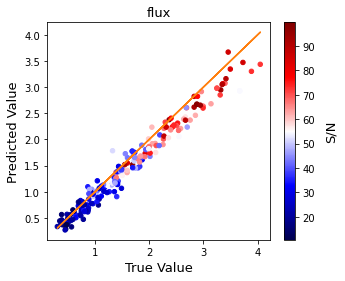

In [61]:
plot_prediction(cnnmodel, 0)

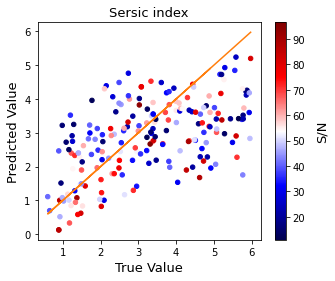

In [62]:
plot_prediction(cnnmodel, 1)

![alt text](https://)

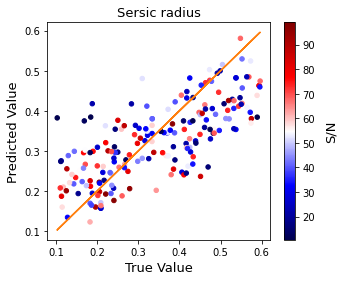

In [63]:
plot_prediction(cnnmodel, 2)

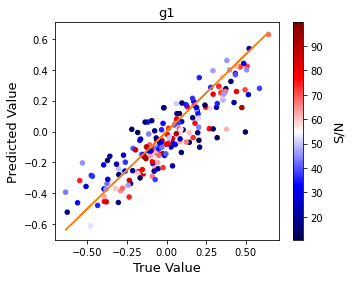

In [64]:
plot_prediction(cnnmodel, 3)

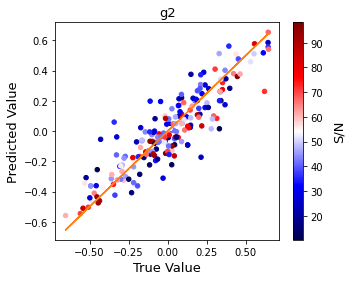

In [65]:
plot_prediction(cnnmodel, 4)